# Computational Methods in Bayesian Analysis

In the final example from the previous section, the problem was deliberately chosen so that a result could be calculated by hand: there were only two possible parameter values for the likelihood, so the normalizing constant of Bayes' formula was just a sum of two terms.

For most problems of interest, Bayesian analysis requires integration over multiple parameters, making the calculation of a posterior intractable either via analytic methods or standard methods of numerical integration.

However, it is often possible to **approximate** these integrals by simulating
(drawing samples) from posterior distributions. For example, consider the expected value (mean) of a vector-valued random variable $\mathbf{x}$:

\\[\begin{gathered}
\begin{split}E[{\bf x}] = \int {\bf x} f({\bf x}) d{\bf x}, \qquad
{\bf x} = \{x_1,...,x_k\}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}
\\]

where $k$ (the dimension of vector $x$) is perhaps very large. 

If we can produce a reasonable number of **random vectors** $\{{\bf x_i}\}$, we can use these values to approximate the unknown integral. This process is known as *Monte Carlo integration*. In general, MC integration allows integrals against probability density functions:

\\[\begin{gathered}
\begin{split}I = \int h(\mathbf{x}) f(\mathbf{x}) \mathbf{dx}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}
\\]

to be estimated by finite sums:

\\[\begin{gathered}
\begin{split}\hat{I} = \frac{1}{n}\sum_{i=1}^n h(\mathbf{x}_i),\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}
\\]

where $\mathbf{x}_i$ is a sample from $f$. This estimate is valid and useful because:

-   By the strong law of large numbers:

$$\begin{gathered}
\begin{split}\hat{I} \rightarrow I   \mbox{   with probability 1}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

-   Simulation error can be measured and controlled:

$$Var(\hat{I}) = \frac{1}{n(n-1)}\sum_{i=1}^n
   (h(\mathbf{x}_i)-\hat{I})^2$$
   

### Example: negative binomial distribution

We can use simulation to estimate the expected value of a random variable that is negative binomial-distributed. The negative binomial distribution describes some postive discrete random variables; In particular, it can be used to model the number of Bernoulli trials that one can expect to conduct until \\(r\\) failures occur.


\\[
f(x \mid p, r) = \frac{x+r-1}{x} (1-p)^x p^r
\\]

Where:
    
- \\(0 < p < 1\\)
- \\(r \in \{1, 2, 3, \ldots \}\\)

and:

- \\(x \in \{0, 1, 2, \ldots \}\\)

![negative binomial (courtesy Wikipedia)](http://upload.wikimedia.org/wikipedia/commons/8/83/Negbinomial.gif)

Most frequently, however, it is used to model **overdispersed counts**. That is, counts that have a larger variance than would be predicted under a Poisson distribution. In fact, the negative binomial can be expressed as a continuous mixture of Poisson distributions, where a gamma distribution acts as the mixing distribution.

\\[f(x \mid p, r) = \int_0^{\infty} \text{Poisson}(\lambda) \, \text{Gamma}(r, (1-p)/p) \, d\lambda
\\]

Lets use simulation to try to estimate the mean of a negative binomial distribution with \\(p = 0.7\\) and \\(r = 3\\):

In [1]:
# Simulate gamma means
import numpy as np
r = 3
p = 0.7

lam = np.random.gamma(r, p/(1.-p), size=100)

In [2]:
# Simulate sample Poisson conditional on lambda
sim_vals = np.random.poisson(lam)
sim_vals.sum() / 100.

6.62

The actual expected value of the negative binomial distribution is \\(p r / (1-p)\\), which in this case is 7. That's pretty close, though we can do better if we draw more samples:

In [3]:
lam = np.random.gamma(r, p/(1.-p), size=100000)
sim_vals = np.random.poisson(lam)
sim_vals.sum() / 100000.

6.9613

This approach of drawing repeated random samples in order to obtain a desired numerical result is generally known as **Monte Carlo simulation**.

Clearly, this is a convenient, simplistic example that did not require simuation to obtain an answer. For most problems, it is simply not possible to draw independent random samples from the posterior distribution because they will generally be (1) multivariate and (2) not of a known functional form for which there is a pre-existing random number generator.

However, we are not going to give up on simulation. Though we cannot generally draw independent samples for our model, we can usually generate **dependent** samples, and it turns out that if we do this in a particular way, we can obtain samples from almost any posterior distribution.

## Markov Chains

A Markov chain is a special type of *stochastic process*. The standard definition of a stochastic process is an ordered collection of random variables:

$$\begin{gathered}
\begin{split}\{X_t:t \in T\}\end{split}\notag\\\begin{split}\end{split}\notag
\end{gathered}$$

where $t$ is frequently (but not necessarily) a time index. If we think of $X_t$ as a state $X$ at time $t$, and invoke the following dependence condition on each state:

\\[\begin{aligned}
&Pr(X_{t+1}=x_{t+1} | X_t=x_t, X_{t-1}=x_{t-1},\ldots,X_0=x_0) \cr
&= Pr(X_{t+1}=x_{t+1} | X_t=x_t)
\end{aligned}\\]

then the stochastic process is known as a Markov chain. This conditioning specifies that the future depends on the current state, but not past states. Thus, the Markov chain wanders about the state space,
remembering only where it has just been in the last time step. 

The collection of transition probabilities is sometimes called a *transition matrix* when dealing with discrete states, or more generally, a *transition kernel*.

It is useful to think of the Markovian property as **mild non-independence**. 

If we use Monte Carlo simulation to generate a Markov chain, this is called **Markov chain Monte Carlo**, or MCMC. If the resulting Markov chain obeys some important properties, then it allows us to indirectly generate independent samples from a particular posterior distribution.


> ### Why MCMC Works: Reversible Markov Chains
> 
> Markov chain Monte Carlo simulates a Markov chain for which some function of interest
> (*e.g.* the joint distribution of the parameters of some model) is the unique, invariant limiting distribution. An invariant distribution with respect to some Markov chain with transition kernel $Pr(y \mid x)$ implies that:
> 
> $$\int_x Pr(y \mid x) \pi(x) dx = \pi(y).$$
> 
> Invariance is guaranteed for any *reversible* Markov chain. Consider a Markov chain in reverse sequence:
> $\{\theta^{(n)},\theta^{(n-1)},...,\theta^{(0)}\}$. This sequence is still Markovian, because:
> 
> $$Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x,\theta^{(k+2)}=x_1,\ldots ) = Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x)$$
> 
> Forward and reverse transition probabilities may be related through Bayes theorem:
> 
> $$\frac{Pr(\theta^{(k+1)}=x \mid \theta^{(k)}=y) \pi^{(k)}(y)}{\pi^{(k+1)}(x)}$$
> 
> Though not homogeneous in general, $\pi$ becomes homogeneous if:
> 
> -   $n \rightarrow \infty$
> 
> -   $\pi^{(i)}=\pi$ for some $i < k$
> 
> If this chain is homogeneous it is called reversible, because it satisfies the ***detailed balance equation***:
> 
> $$\pi(x)Pr(y \mid x) = \pi(y) Pr(x \mid y)$$
> 
> Reversibility is important because it has the effect of balancing movement through the entire state space. When a Markov chain is reversible, $\pi$ is the unique, invariant, stationary distribution of that chain. Hence, if $\pi$ is of interest, we need only find the reversible Markov chain for which $\pi$ is the limiting distribution.
> This is what MCMC does!

## Gibbs Sampling

The Gibbs sampler is the simplest and most prevalent MCMC algorithm. If a posterior has $k$ parameters to be estimated, we may condition each parameter on current values of the other $k-1$ parameters, and sample from the resultant distributional form (usually easier), and repeat this operation on the other parameters in turn. This procedure generates samples from the posterior distribution. Note that we have now combined Markov chains (conditional independence) and Monte Carlo techniques (estimation by simulation) to yield Markov chain Monte Carlo.

Here is a stereotypical Gibbs sampling algorithm:

1.  Choose starting values for states (parameters):
    ${\bf \theta} = [\theta_1^{(0)},\theta_2^{(0)},\ldots,\theta_k^{(0)}]$

2.  Initialize counter $j=1$

3.  Draw the following values from each of the $k$ conditional
    distributions:

    $$\begin{aligned}
    \theta_1^{(j)} &\sim& \pi(\theta_1 | \theta_2^{(j-1)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
    \theta_2^{(j)} &\sim& \pi(\theta_2 | \theta_1^{(j)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
    \theta_3^{(j)} &\sim& \pi(\theta_3 | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
    \vdots \\
    \theta_{k-1}^{(j)} &\sim& \pi(\theta_{k-1} | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_k^{(j-1)}) \\
    \theta_k^{(j)} &\sim& \pi(\theta_k | \theta_1^{(j)},\theta_2^{(j)},\theta_4^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_{k-1}^{(j)})\end{aligned}$$

4.  Increment $j$ and repeat until convergence occurs.

As we can see from the algorithm, each distribution is conditioned on the last iteration of its chain values, constituting a Markov chain as advertised. The Gibbs sampler has all of the important properties outlined in the previous section: it is aperiodic, homogeneous and ergodic. Once the sampler converges, all subsequent samples are from the target distribution. This convergence occurs at a geometric rate.

## Example: Inferring patterns in UK coal mining disasters

Let's try to model a more interesting example, a time series of recorded coal mining 
disasters in the UK from 1851 to 1962.

Occurrences of disasters in the time series is thought to be derived from a 
Poisson process with a large rate parameter in the early part of the time 
series, and from one with a smaller rate in the later part. We are interested 
in locating the change point in the series, which perhaps is related to changes 
in mining safety regulations.

In [4]:
disasters_array = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

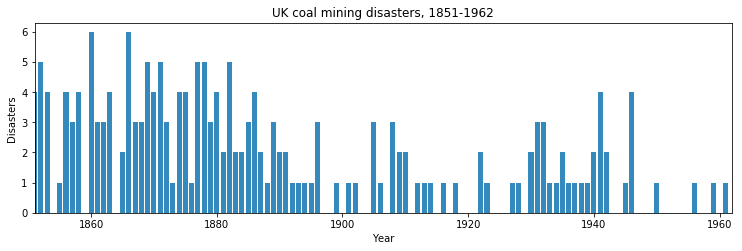

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12.5, 3.5))
n_count_data = len(disasters_array)
plt.bar(np.arange(1851, 1962), disasters_array, color="#348ABD")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962);

We are going to use [Poisson](http://en.wikipedia.org/wiki/Poisson_distribution) random variables for this type of count data. Denoting year $i$'s accident count by $y_i$, 

$$ y_i \sim \text{Poisson}(\lambda) $$

For those unfamiliar, Poisson random variables look like this:

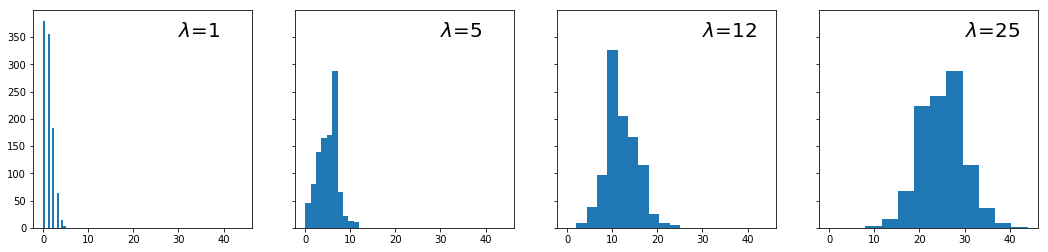

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(18,4), sharex=True, sharey=True)
for i,l in enumerate([1, 5, 12, 25]):
    axes[i].hist(np.random.poisson(l, 1000), histtype="stepfilled")
    axes[i].annotate(r'$\lambda$=%i' % l, xy=(1, 1), xytext=(30, 350), fontsize=20)

The modeling problem revolves around estimating the values of the $\lambda$ parameters. Looking at the time series above, it appears that the rate declines later in the time series.

A ***changepoint model*** identifies a point (year) during the observation period (call it $\tau$) after which the parameter $\lambda$ drops to a lower value. So we are estimating two $\lambda$ parameters: one for the early period and another for the late period.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We need to assign prior probabilities to both $\lambda$ parameters. The [gamma distribution](http://en.wikipedia.org/wiki/Gamma_distribution) not only provides a continuous density function for positive numbers, but it is also **conjugate** with the Poisson sampling distribution. 

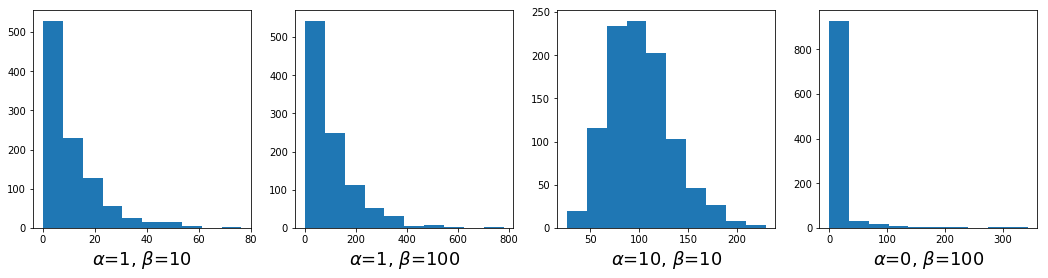

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(18,4))
for i,p in enumerate([(1, 10), (1, 100), (10, 10), (0.1, 100)]):
    axes[i].hist(np.random.gamma(*p, size=1000), histtype="stepfilled")
    axes[i].set_xlabel(r'$\alpha$=%i, $\beta$=%i' % (p[0], p[1]), fontsize=18)

We will specify suitably vague hyperparameters $\alpha$ and $\beta$ for both priors.

\begin{align}
&\lambda_1 \sim \text{Gamma}( 1, 10 ) \\\
&\lambda_2 \sim \text{Gamma}( 1, 10 )
\end{align}

Since we do not have any intuition about the location of the changepoint (prior to viewing the data), we will assign a discrete uniform prior over all years 1851-1962.

\begin{align}
& \tau \sim \text{DiscreteUniform(1851,1962) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{111}
\end{align}

### Implementing Gibbs sampling

We are interested in estimating the joint posterior of $\lambda_1, \lambda_2$ and $\tau$ given the array of annnual disaster counts $\mathbf{y}$. This gives:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(\mathbf{y} | \lambda_1, \lambda_2, \tau ) P(\lambda_1, \lambda_2, \tau) 
$$

To employ Gibbs sampling, we need to factor the joint posterior into the product of conditional expressions:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(y_{t<\tau} | \lambda_1, \tau) P(y_{t\ge \tau} | \lambda_2, \tau) P(\lambda_1) P(\lambda_2) P(\tau)
$$

which we have specified as:

$$\begin{aligned}
P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) &\propto \left[\prod_{t=1851}^{\tau} \text{Poi}(y_t|\lambda_1) \prod_{t=\tau+1}^{1962} \text{Poi}(y_t|\lambda_2) \right] \text{Gamma}(\lambda_1|\alpha,\beta) \text{Gamma}(\lambda_2|\alpha, \beta) \frac{1}{111} \\
&\propto \left[\prod_{t=1851}^{\tau} e^{-\lambda_1}\lambda_1^{y_t} \prod_{t=\tau+1}^{1962} e^{-\lambda_2} \lambda_2^{y_t} \right] \lambda_1^{\alpha-1} e^{-\beta\lambda_1} \lambda_2^{\alpha-1} e^{-\beta\lambda_2} \\
&\propto \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}
\end{aligned}$$

So, the full conditionals are known, and critically for Gibbs, can easily be sampled from.

$$\lambda_1 \sim \text{Gamma}(\sum_{t=1851}^{\tau} y_t +\alpha, \tau+\beta)$$
$$\lambda_2 \sim \text{Gamma}(\sum_{t=\tau+1}^{1962} y_i + \alpha, 1962-\tau+\beta)$$
$$\tau \sim \text{Categorical}\left( \frac{\lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}}{\sum_{k=1851}^{1962} \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}} \right)$$

Implementing this in Python requires random number generators for both the gamma and discrete uniform distributions. We can leverage NumPy for this:

In [8]:
# Function to draw random gamma variate
rgamma = np.random.gamma

def rcategorical(probs, n=None):
    # Function to draw random categorical variate
    return np.array(probs).cumsum().searchsorted(np.random.sample(n))

Next, in order to generate probabilities for the conditional posterior of $\tau$, we need the kernel of the gamma density:

\\[\lambda^{\alpha-1} e^{-\beta \lambda}\\]

In [9]:
dgamma = lambda lam, a, b: lam**(a-1) * np.exp(-b*lam)

Diffuse hyperpriors for the gamma priors on $\lambda_1, \lambda_2$:

In [10]:
alpha, beta = 1., 10

For computational efficiency, it is best to pre-allocate memory to store the sampled values. We need 3 arrays, each with length equal to the number of iterations we plan to run:

In [64]:
# Specify number of iterations
n_iterations = 1000

# Initialize trace of samples
lambda1, lambda2, tau = np.zeros((3, n_iterations+1))

The penultimate step initializes the model paramters to arbitrary values:

In [65]:
lambda1[0] = 6
lambda2[0] = 2
tau[0] = 50

In [63]:
#disasters_array[tau[0]:].sum()+alpha
np.random.gamma(57,0.01,10)

array([0.61596529, 0.55489765, 0.70311406, 0.6331818 , 0.52503802,
       0.58121888, 0.68451875, 0.64843957, 0.4338562 , 0.60596562])

Now we can run the Gibbs sampler.

In [70]:
# Sample from conditionals
for i in range(n_iterations):
    # Sample early mean
    lambda1[i+1] = rgamma(disasters_array[:int(tau[i])].sum() + alpha, 1./(tau[i] + beta))
    # Sample late mean
    lambda2[i+1] = rgamma(disasters_array[int(tau[i]):].sum() + alpha, 1./(n_count_data - tau[i] + beta))
    # Sample changepoint: first calculate probabilities (conditional)
    p = np.array([dgamma(lambda1[i+1], disasters_array[:t].sum() + alpha, t + beta)*
             dgamma(lambda2[i+1], 
                    disasters_array[t:].sum() + alpha, 
                    n_count_data - t + beta)
             for t in range(n_count_data)])
    # ... then draw sample
    tau[i+1] = rcategorical(p/p.sum())

Plotting the trace and histogram of the samples reveals the marginal posteriors of each parameter in the model.

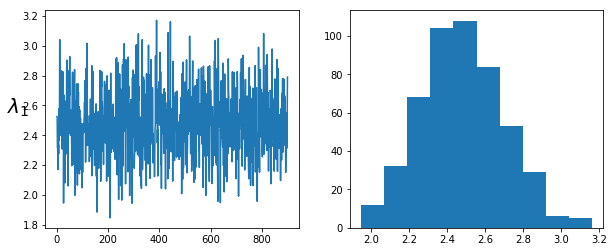

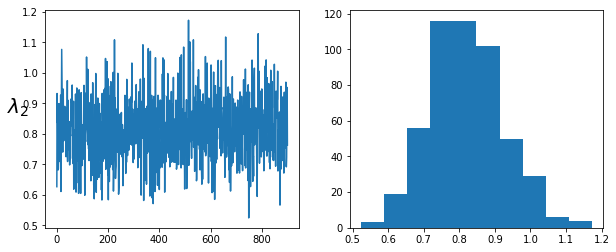

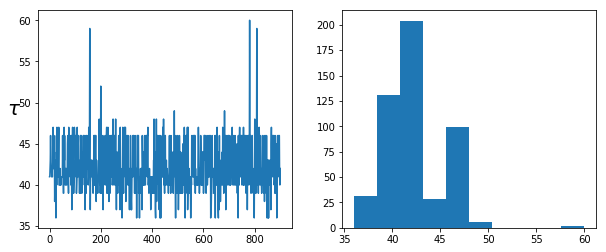

In [71]:
param_dict = {r'$\lambda_1$':lambda1, r'$\lambda_2$':lambda2, r'$\tau$':tau}
for p in param_dict:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(param_dict[p][100:])
    axes[0].set_ylabel(p, fontsize=20, rotation=0)
    axes[1].hist(param_dict[p][int(n_iterations/2):])

## The Metropolis-Hastings Algorithm

The key to success in applying the Gibbs sampler to the estimation of Bayesian posteriors is being able to specify the form of the complete conditionals of
${\bf \theta}$, because the algorithm cannot be implemented without them. In practice, the posterior conditionals cannot always be neatly specified. 


Taking a different approach, the Metropolis-Hastings algorithm generates ***candidate***  state transitions from an alternate distribution, and *accepts* or *rejects* each candidate probabilistically.

Let us first consider a simple Metropolis-Hastings algorithm for a single parameter, $\theta$. We will use a standard sampling distribution, referred to as the *proposal distribution*, to produce candidate variables $q_t(\theta^{\prime} | \theta)$. That is, the generated value, $\theta^{\prime}$, is a *possible* next value for
$\theta$ at step $t+1$. We also need to be able to calculate the probability of moving back to the original value from the candidate, or
$q_t(\theta | \theta^{\prime})$. These probabilistic ingredients are used to define an *acceptance ratio*:

$$\begin{gathered}
\begin{split}a(\theta^{\prime},\theta) = \frac{q_t(\theta^{\prime} | \theta) \pi(\theta^{\prime})}{q_t(\theta | \theta^{\prime}) \pi(\theta)}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

The value of $\theta^{(t+1)}$ is then determined by:

$$\theta^{(t+1)} = \left\{\begin{array}{l@{\quad \mbox{with prob.} \quad}l}\theta^{\prime} & \text{with probability } \min(a(\theta^{\prime},\theta^{(t)}),1) \\ \theta^{(t)} & \text{with probability } 1 - \min(a(\theta^{\prime},\theta^{(t)}),1) \end{array}\right.$$

This transition kernel implies that movement is not guaranteed at every step. It only occurs if the suggested transition is likely based on the acceptance ratio.

A single iteration of the Metropolis-Hastings algorithm proceeds as follows:

1.  Sample $\theta^{\prime}$ from $q(\theta^{\prime} | \theta^{(t)})$.

2.  Generate a Uniform[0,1] random variate $u$.

3.  If $a(\theta^{\prime},\theta) > u$ then
    $\theta^{(t+1)} = \theta^{\prime}$, otherwise
    $\theta^{(t+1)} = \theta^{(t)}$.

The original form of the algorithm specified by Metropolis required that
$q_t(\theta^{\prime} | \theta) = q_t(\theta | \theta^{\prime})$, which reduces $a(\theta^{\prime},\theta)$ to
$\pi(\theta^{\prime})/\pi(\theta)$, but this is not necessary. In either case, the state moves to high-density points in the distribution with high probability, and to low-density points with low probability. After convergence, the Metropolis-Hastings algorithm describes the full target posterior density, so all points are recurrent.

### Random-walk Metropolis-Hastings

A practical implementation of the Metropolis-Hastings algorithm makes use of a random-walk proposal.
Recall that a random walk is a Markov chain that evolves according to:

$$
\theta^{(t+1)} = \theta^{(t)} + \epsilon_t \\
\epsilon_t \sim f(\phi)
$$

As applied to the MCMC sampling, the random walk is used as a proposal distribution, whereby dependent proposals are generated according to:

$$\begin{gathered}
\begin{split}q(\theta^{\prime} | \theta^{(t)}) = f(\theta^{\prime} - \theta^{(t)}) = \theta^{(t)} + \epsilon_t\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

Generally, the density generating $\epsilon_t$ is symmetric about zero,
resulting in a symmetric chain. Chain symmetry implies that
$q(\theta^{\prime} | \theta^{(t)}) = q(\theta^{(t)} | \theta^{\prime})$,
which reduces the Metropolis-Hastings acceptance ratio to:

$$\begin{gathered}
\begin{split}a(\theta^{\prime},\theta) = \frac{\pi(\theta^{\prime})}{\pi(\theta)}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

The choice of the random walk distribution for $\epsilon_t$ is frequently a normal or Student’s $t$ density, but it may be any distribution that generates an irreducible proposal chain.

An important consideration is the specification of the **scale parameter** for the random walk error distribution. Large values produce random walk steps that are highly exploratory, but tend to produce proposal values in the tails of the target distribution, potentially resulting in very small acceptance rates. Conversely, small values tend to be accepted more frequently, since they tend to produce proposals close to the current parameter value, but may result in chains that ***mix*** very slowly.

Some simulation studies suggest optimal acceptance rates in the range of 20-50%. It is often worthwhile to optimize the proposal variance by iteratively adjusting its value, according to observed acceptance rates early in the MCMC simulation .

## Example: Linear model estimation

This very simple dataset is a selection of real estate prices \\(p\\), with the associated age \\(a\\) of each house. We wish to estimate a simple linear relationship between the two variables, using the Metropolis-Hastings algorithm.

**Linear model**:

$$\mu_i = \beta_0 + \beta_1 a_i$$

**Sampling distribution**:

$$p_i \sim N(\mu_i, \tau)$$

**Prior distributions**:

$$\begin{aligned}
& \beta_i \sim N(0, 10000) \cr
& \tau \sim \text{Gamma}(0.001, 0.001)
\end{aligned}$$

In [89]:
age = np.array([13, 14, 14,12, 9, 15, 10, 14, 9, 14, 13, 12, 9, 10, 15, 11, 
                15, 11, 7, 13, 13, 10, 9, 6, 11, 15, 13, 10, 9, 9, 15, 14, 
                14, 10, 14, 11, 13, 14, 10])

price = np.array([2950, 2300, 3900, 2800, 5000, 2999, 3950, 2995, 4500, 2800, 
                  1990, 3500, 5100, 3900, 2900, 4950, 2000, 3400, 8999, 4000, 
                  2950, 3250, 3950, 4600, 4500, 1600, 3900, 4200, 6500, 3500, 
                  2999, 2600, 3250, 2500, 2400, 3990, 4600, 450,4700])/1000.

To avoid numerical underflow issues, we typically work with log-transformed likelihoods, so the joint posterior can be calculated as sums of log-probabilities and log-likelihoods.

This function calculates the joint log-posterior, conditional on values for each parameter:

In [90]:
from scipy.stats import distributions
dgamma = distributions.gamma.logpdf
dnorm = distributions.norm.logpdf

def calc_posterior(a, b, t, y=price, x=age):
    # Calculate joint posterior, given values for a, b and t

    # Priors on a,b
    logp = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    # Prior on t
    logp += dgamma(t, 0.001, 0.001)
    # Calculate mu
    mu = a + b*x
    # Data likelihood
    logp += sum(dnorm(y, mu, t**-2))
    
    return logp

The `metropolis` function implements a simple random-walk Metropolis-Hastings sampler for this problem. It accepts as arguments:

- the number of iterations to run
- initial values for the unknown parameters
- the variance parameter of the proposal distribution (normal)

In [93]:
rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print ('Iteration', i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

Let's run the MH algorithm with a very small proposal variance:

In [94]:
n_iter = 10000
trace, acc = metropolis(n_iter, (1,0,1), 0.001)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


We can see that the acceptance rate is way too high:

In [95]:
np.array(acc, float)/n_iter

array([0.9721, 0.9602, 0.9604])

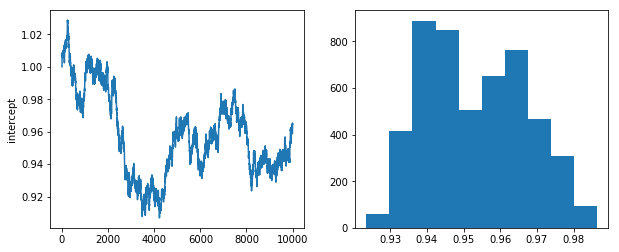

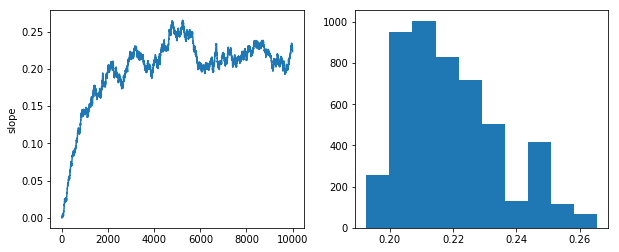

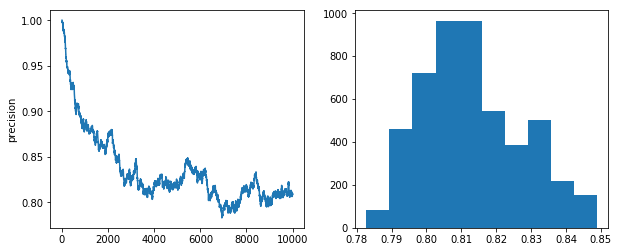

In [97]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace.T):
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

Now, with a very large proposal variance:

In [98]:
trace_hivar, acc = metropolis(n_iter, (1,0,1), 10)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [99]:
np.array(acc, float)/n_iter

array([0.0303, 0.0022, 0.0068])

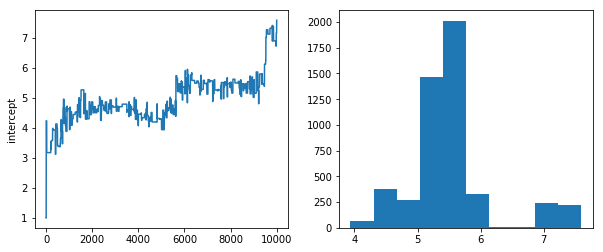

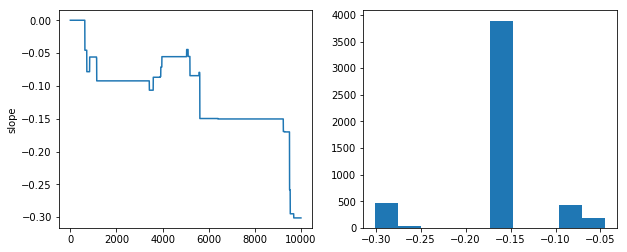

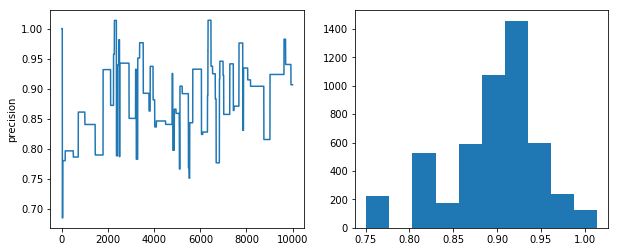

In [101]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_hivar.T):
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

### Adaptive Metropolis

In order to avoid having to set the proposal variance by trial-and-error, we can add some tuning logic to the algorithm. The following implementation of Metropolis-Hastings reduces proposal variances  by 10% when the acceptance rate is low, and increases it by 10% when the acceptance rate is high.

In [103]:
def metropolis_tuned(n_iterations, initial_values, prop_var=1, 
                     tune_for=None, tune_interval=100):
    
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var] * n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    if tune_for is None:
        tune_for = n_iterations/2
    
    for i in range(n_iterations):
    
        if not i%1000: print ('Iteration', i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for):
        
                # Calculate aceptance rate
                acceptance_rate = (1.*accepted[j])/tune_interval
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.5:
                    prop_sd[j] *= 1.1
        
                accepted[j] = 0
                
    return trace[tune_for:], accepted

In [104]:
trace_tuned, acc = metropolis_tuned(n_iter, (1,0,1), prop_var=1, tune_for=9000)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [105]:
np.array(acc, float)/(n_iter-9000)

array([0.315, 0.273, 0.277])

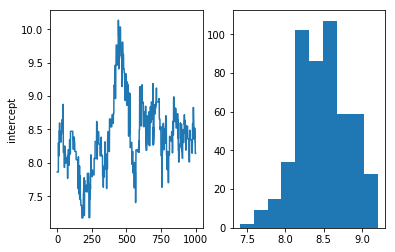

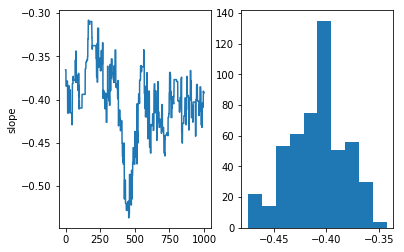

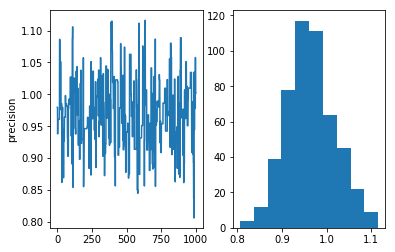

In [107]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_tuned.T):
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])

50 random regression lines drawn from the posterior:

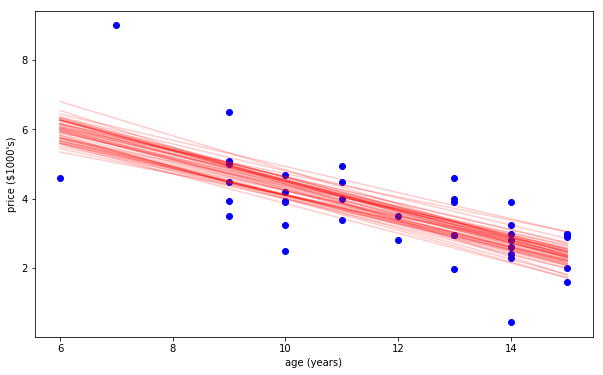

In [108]:
plt.figure(figsize=(10,6))
plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1,tau = trace_tuned[np.random.randint(0, 1000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

## Exercise: Bioassay analysis

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is `death`, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

<div style="font-size: 150%;">  
$$\begin{aligned}
y_i &\sim \text{Bin}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$
</div>

The common statistic of interest in such experiments is the **LD50**, the dosage at which the probability of death is 50%.

Use Metropolis-Hastings sampling to fit a Bayesian model to analyze this bioassay data, and to estimate LD50.

In [126]:
# Log dose in each group
log_dose = np.array([-.86, -.3, -.05, .73])

# Sample size in each group
n = 5

# Outcomes
deaths = [0, 1, 3, 5]

In [127]:
from scipy.stats import distributions
dbin = distributions.binom.logpmf
dnorm = distributions.norm.logpdf

invlogit = lambda x: 1./(1 + np.exp(-x))

def calc_posterior(a, b, y=deaths, x=log_dose):

    # Priors on a,b
    logp = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    # Calculate p
    p = invlogit(a + b*x)
    # Data likelihood
    logp += sum([dbin(yi, n, pi) for yi,pi in zip(y,p)])
    
    return logp

In [128]:
trace_tuned, acc = metropolis_tuned(n_iter, (1,0), prop_var=1, tune_for=9000)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


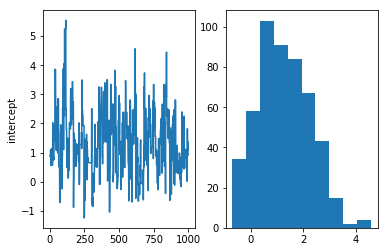

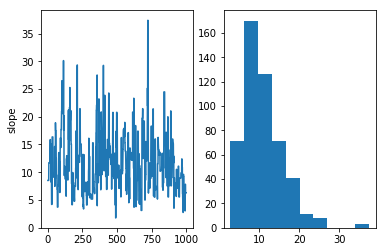

In [125]:
for param, samples in zip(['intercept', 'slope'], trace_tuned.T):
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])

---

In [129]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()